# GIF generation using the TiTiler /cog/feature endpoint

This notebook demonstrates how to use the `cog/feature` endpoint to generate GIFs from data in the VEDA API. 

The overall process will be: 
1. Use the STAC API to gather a list of STAC Items which will each become on frame in our gif
2. Query the `/cog/feater` endpoint with the asset URL and a geojson geometry
3. Stack all of the generated images into a animated GIF

## Import relevant libraries

In [1]:
# Standard lib imports
from concurrent.futures import ThreadPoolExecutor
import datetime
import glob
import json
import os
import requests
import tempfile
import time
import io
from IPython import display

# 3rd party imports
import folium
import numpy as np

# import PIL
from PIL import Image, ImageFont, ImageDraw
import rasterio
import rasterio.features
import rasterio.plot

In [2]:
!pip install -q selenium webdriver_manager==3.9.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.1 requires xgcm<0.7.0, but you have xgcm 0.8.1 which is incompatible.


## Define global variables

In [3]:
STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

# Collection we'll be using to generate the GIF
collection = "no2-monthly"

## Define an AOI to crop the COG data

We can fetch GeoJSON for metropolitan France and Corsica (excluding overseas territories) from an authoritative online source (https://gadm.org/download_country.html).

In [4]:
response = requests.get(
    "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_0.json"
)

# If anything goes wrong with this request output error contents
assert response.ok, response.text

result = response.json()
print(f"There are {len(result['features'])} features in this collection")

There are 1 features in this collection


That is the geojson for a feature collection, but since there is only one feature in it we can grab just that.

In [5]:
france_aoi = result["features"][0]

Let's take a look at this AOI on a map

In [6]:
m = folium.Map(
    location=[45, 0],
    zoom_start=5,
)

folium.GeoJson(france_aoi, name="France").add_to(m)
m

## Search STAC API for available data

In [7]:
# NO2 monthly has a global extent, so we don't need to specify an area within
# which to search. For non-global datasets, use the `bbox` parameter to specify
# the bounding box within which to search.
items = requests.get(f"{STAC_API_URL}/collections/{collection}/items?limit=100").json()[
    "features"
]

In [8]:
# Available dates:
dates = [item["properties"]["start_datetime"] for item in items]
print(f"Dates available: {dates[:5]} ... {dates[-5:]}")

Dates available: ['2023-09-01T00:00:00', '2023-08-01T00:00:00', '2023-07-01T00:00:00', '2023-06-01T00:00:00', '2023-05-01T00:00:00'] ... ['2016-05-01T00:00:00', '2016-04-01T00:00:00', '2016-03-01T00:00:00', '2016-02-01T00:00:00', '2016-01-01T00:00:00']


## The /cog/feature endpoint

The endpoint accepts the following parameters, among others: 
- format (tif, jpeg, webp, etc)
- height and width
- url (for the COG file to extract data from)

And any other visualization parameters specific to that dataset (eg: rescale and color_map values)

### Get visualization parameters: 

In [9]:
item = items[0]
item_stats = item['assets']['cog_default']['raster:bands'][0]['statistics']
min, max = item_stats['minimum'], item_stats['maximum']

### Generate a PNG!

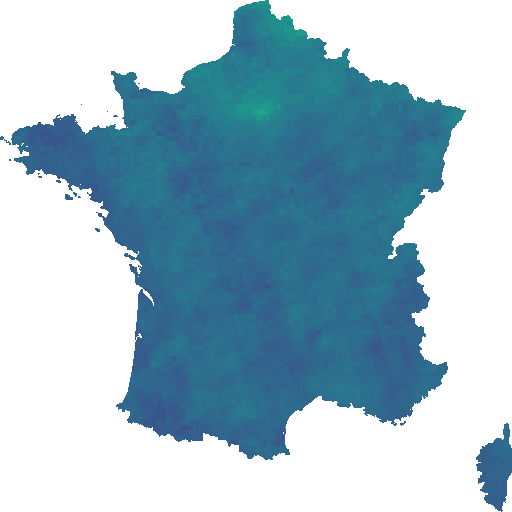

In [10]:
# get PNG bytes from API
response = requests.post(
    f"{RASTER_API_URL}/cog/feature",
    params={
        "format": "png",
        "height": 512,
        "width": 512,
        "url": items[0]["assets"]["cog_default"]["href"],
        "rescale": f"{min},{max}",
        "colormap_name": "viridis",
    },
    json=france_aoi,
)

assert response.ok, response.text

image_bytes = response.content

# Write to temporary file in order to display
f = tempfile.NamedTemporaryFile(suffix=".png")
f.write(image_bytes)

# display PNG!
display.Image(filename=f.name, height=512, width=512)

## Generating a GIF

To generate a GIF we request a PNG for each STAC Item and then use the Python Imaging Library (PIL) to combine them into a GIF. We will use a temporary directory to store all the generated PNGs and we will use multi-threading to speed up the operation

Gather frames: 17.11 seconds


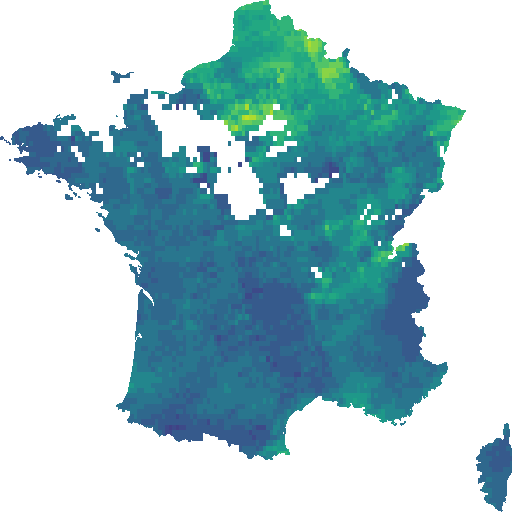

In [11]:
# for convenience we will wrap the API call from above into a method that will
# save the contents of the image file into a file stored within the temp directory
from gif_generation_dependencies.helper_functions import generate_frame

# temporary directory to hold PNGs
with tempfile.TemporaryDirectory() as tmpdirname:

    start = time.time()

    args = (
        (
            item,  # stac item
            france_aoi,  # aoi to crop
            tmpdirname,  # tmpdir (optional)
            "png",  # image format
            None,  # overlay (will be discussed further)
            {
                "rescale": f"{min},{max}",
                "colormap_name": "viridis",
            },  # visualization parameters
        )
        for item in items
    )

    with ThreadPoolExecutor(max_workers=10) as executor:
        result = list(executor.map(lambda a: generate_frame(*a), args))

    end = time.time()

    print(f"Gather frames: {round((end-start), 2)} seconds")

    imgs = (Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.png"))))
    img = next(imgs)  # extract first image from iterator
    img.save(
        fp="./output.gif",
        format="GIF",
        append_images=imgs,
        save_all=True,
        duration=300,
        loop=0,
    )

display.Image(filename="./output.gif")

## Adding context

To provide more interesting or engaging data to the users, we can add temporal and geospatial context to the GIF. This is possible because API can return images in geo-referenced tif format. 

In [12]:
with tempfile.TemporaryDirectory() as tmpdirname:

    filepath = generate_frame(items[0], france_aoi, tmpdirname, image_format="tif")

    # Verify that the tif returned by the API is correctly georeferenced
    georeferenced_raster_data = rasterio.open(filepath)

    print("Data bounds: ", georeferenced_raster_data.bounds)
    print("Data CRS: ", georeferenced_raster_data.crs)

Data bounds:  BoundingBox(left=-5.143799999999999, bottom=41.3338, right=9.560400000000016, top=51.0894)
Data CRS:  EPSG:4326


### Overlaying GeoJSON: 
In order to overlay GeoJSON over the raster, we will have to convert the geojson boundaries to a raster format. We do this with the following steps: 

For each feature in the geojson we rasterize the feature into a mask. We use [binary dialation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html?highlight=binary%20dilation#scipy.ndimage.binary_dilation) to detect the edges of the mask, and set the values corresponding to the mask edges to 255. This approach has one known problem: if multiple features share a border (eg: two adjoining provinces) the border between then will be detected twice, once from each side (or from each feature sharing that border). This means that internal borders will be twice as thick as external borders     

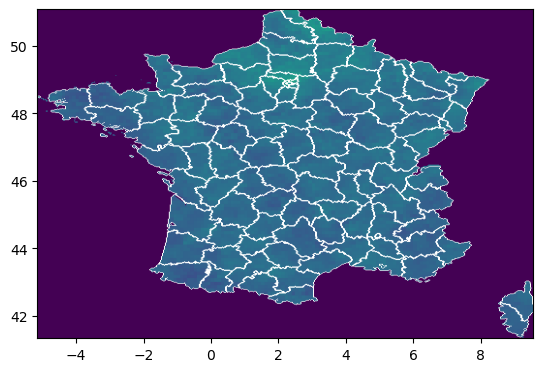

In [13]:
from gif_generation_dependencies.helper_functions import overlay_geojson

with tempfile.TemporaryDirectory() as tmpdirname:
    with open("./gif_generation_dependencies/france-departements.geojson", "r") as f:
        geojson = json.loads(f.read())

    filepath = generate_frame(
        items[0],
        france_aoi,
        tmpdirname,
        image_format="tif",
        additional_cog_feature_args={
            "rescale": f"{min},{max}",
            "colormap_name": "viridis",
        },
    )

    filepath = overlay_geojson(filepath, geojson)
    rasterio.plot.show(rasterio.open(filepath))

### Overlaying the raster on a basemap
Another way to contextualize where in the GIF's data is, is by overlaying the GIF on top of a base map. This process is a bit more complicated: 
- Generate a raster image (.tif)
- Overlay in on a folium map interface
- Save the map interface to html
- Open the html file with a headless chrome webdriver (using the selenium library)
- Save a screenshot of the rendered html as a .png

In [14]:
from gif_generation_dependencies.helper_functions import overlay_raster_on_folium

tmpdirname = tempfile.TemporaryDirectory()

image_filepath = generate_frame(
    items[0],
    france_aoi,
    tmpdirname.name,
    image_format="tif",
    overlay=None,
    additional_cog_feature_args={
        "rescale": f"{min},{max}",
        "colormap_name": "viridis",
    },
)

image_filepath = overlay_raster_on_folium(image_filepath)

display.Image(filename=image_filepath)

TypeError: expected string or bytes-like object

### Overlaying the Date: 
Now that we have the raster data displayed over the basemap, we want to add the date of each file 

In [ ]:
from gif_generation_dependencies.helper_functions import overlay_date

date = items[0]["properties"]["start_datetime"]

# get datestring from STAC Item properties and reformat
datestring = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").date().isoformat()

# Reuse the raster overlayed on the OSM basemap using folium from above:
overlay_date(image_filepath, datestring)

display.Image(filename=image_filepath)

## Putting it all together

I've combined all of the above functionality, along with a few helper functions in the file: `./gif_generation_dependencies/helper_functions.py`

I've also added the contextualizaiton steps (overlaying geojson, date, and folium basemap) directly into the `generate_frame()` method

## Generate a GIF with geojson overlay: 

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    start = time.time()

    with open("./gif_generation_dependencies/france-departements.geojson", "r") as f:
        overlay = json.loads(f.read())

    args = (
        (
            item,
            france_aoi,
            tmpdirname,
            "tif",
            geojson,
            {
                "rescale": f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
                "colormap_name": "viridis",
            },
        )
        for item in items
    )

    with ThreadPoolExecutor(max_workers=10) as executor:
        result = list(executor.map(lambda a: generate_frame(*a), args))

    end = time.time()

    print(f"Gather frames: {round((end-start), 2)} seconds")

    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.tif")))]
    imgs[0].save(
        fp="./output_with_geojson.gif",
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=300,
        loop=0,
    )

display.Image(filename="./output_with_geojson.gif")

## GIF with OSM basemap (folium)

In [ ]:
with tempfile.TemporaryDirectory() as tmpdirname:
    start = time.time()

    args = (
        (
            item,
            france_aoi,
            tmpdirname,
            "tif",
            "folium",
            {
                "rescale": f"{COG_DEFAULT['min']},{COG_DEFAULT['max']}",
                "colormap_name": "viridis",
            },
        )
        for item in items
    )

    with ThreadPoolExecutor(max_workers=10) as executor:
        result = list(executor.map(lambda a: generate_frame(*a), args))

    end = time.time()

    print(f"Gather frames: {round((end-start), 2)} seconds")

    # Note: I'm searching for `*.png` files instead of *.tif files because the webdriver screenshot
    # of the folium map interface is exported in png format (this also helps reduce the size of
    # the final gif )
    imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(tmpdirname, "*.png")))]
    imgs[0].save(
        fp="./output_with_osm_basemap.gif",
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=300,
        loop=0,
    )

display.Image(filename="./output_with_osm_basemap.gif")

## Cleanup: 
Run the following cell to remove the following generated images/gifs: 
- `output.gif`
- `output_with_geojson.gif` 
- `output_with_osm_basemap.gif`

In [ ]:
for f in glob.glob(os.path.join(".", "output*.gif")):
    os.remove(f)